# Práctica 5: Tech evolution. Caso POS Tagging

Cesar Cossio Guerrero

**Fecha de entrega: 13 de Abril 2025 11:59pm**

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

## Cargamos todas las **librerías** y **funciones** para cargar el modelo y procesarlo. Todas ellas fueron copiadas del nootebook visto en clase

In [1]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import nltk
nltk.download('reuters')
nltk.download('stopwords')

from nltk.corpus import reuters
from nltk import ngrams
from nltk.corpus import stopwords

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import string
import random
from sklearn.cluster import KMeans
import numpy as np

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

## **Paso 1**: Obten los **embeddings** de **100** palabras al azar del modelo **RNN** visto en clase

## Cargamos los archivos que son los **diccionarios** de **índices** con **palabras** y **POS**.

In [38]:
import pickle

with open('word2idx', 'rb') as f:
  word_2_idx = pickle.load(f)

with open('pos2idx', 'rb') as f:
  pord_2_idx = pickle.load(f)

with open('idx2pos', 'rb') as f:
  idx_2_pos = pickle.load(f)

with open('idx2word', 'rb') as f:
  idx_2_word = pickle.load(f)

## Cargamos el **modelo** entrenado en clase que se encuentra en la carpeta '/content/' usada en este notebook

In [39]:
PATH = "/content/pos_tagger_rnn_cpu_9.pth"

In [40]:
# Setup de parametros
EMBEDDING_DIM=100
vocab_len = 401296 # len(vocabulary)
embedding_table = torch.randn((LV + 2, EMBEDDING_DIM)) / 10

In [41]:
# Ensure the model architecture matches the saved state dict
model = loaded_rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pord_2_idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to('cpu')

### Obtenemos los **embeddings**

In [42]:
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [43]:
embeddings = model.embedding.weight.data

In [44]:
embeddings[0]

tensor([ 0.1304, -0.0016, -0.0028,  0.2793, -0.0762,  0.1087,  0.0525,  0.1281,
        -0.0346,  0.0359, -0.0465,  0.0804, -0.0878, -0.1213,  0.1231,  0.0822,
        -0.1724, -0.0094,  0.1056,  0.0732, -0.0328, -0.1560,  0.0631,  0.1577,
         0.0550, -0.0230,  0.0534, -0.1422,  0.0926,  0.1143, -0.1167, -0.1434,
        -0.0346,  0.0306, -0.1382,  0.1427,  0.0648, -0.1343,  0.1040, -0.0098,
        -0.0310,  0.0635, -0.1071, -0.1535,  0.1036, -0.1717,  0.2010,  0.2250,
         0.1139, -0.0486,  0.1100,  0.0859,  0.1133, -0.1726, -0.0232,  0.1096,
         0.0926,  0.2049, -0.2027,  0.1539,  0.1481, -0.0017, -0.0108, -0.0726,
         0.1515,  0.0187,  0.1211, -0.0652, -0.0494,  0.1746,  0.0226, -0.0191,
        -0.2657, -0.1202,  0.1387,  0.3436,  0.0222,  0.2151, -0.0861, -0.0167,
        -0.0254, -0.0500, -0.0136, -0.0407, -0.1912, -0.0769, -0.0284, -0.0154,
        -0.2178, -0.0360,  0.0132, -0.0678,  0.0554, -0.0791, -0.0412,  0.0822,
        -0.0261, -0.1505,  0.0212,  0.18

### Cabe mencionar que  no pude cargar el modelo que nos pasaron en la carpeta del drive ya que se presentaba un problema en el tamaño del modelo guardado en el archivo y las especificaciones del modelo de la práctica 5. Dado esto entrené nuevamente el model RNN bidireccional de la libreta de la práctica 5. Por tanto pueden ser un poco diferentes a los que da el modelo de la carpeta del drive.


## **Paso 2**: Aplica un algoritmo de **clusterización** a las palabras y **plotearlas en 2D** (Aplica algun **color** para los diferentes clusters)

### Definimos una función que **predice** la etiqueta **POS** de una **palabra**

In [45]:
def predict_pos_tag(model, word_id, idx_2_pos):

    """
    Predicts the POS tag for a given word using the trained model.

    Parámetros: modelo: El modelo RNN
                word_id: El índice de la palabra
                idx_2_pos: Un diccionario que dado un índice regresa la etiqueta POS

    Regresa: La etiqueta predicha para la palabra correspondiente al índice word_id

    """

    model.eval()  # Set the model to evaluation mode
    predicted_pos_tag = {}
    for i in word_id:

      with torch.no_grad():
          input_tensor = torch.tensor([[i]])  # Create a tensor for the input word

          # Forward pass through the model
          output = model(input_tensor)

          # Get the prediction for the single word
          # Assuming the output is logits for each class
          predicted_logits = output[0, 0, :]
          predicted_tag_index = torch.argmax(predicted_logits).item()

          # Get the actual POS tag from the index
          predicted_pos_tag[i] = idx_2_pos.get(predicted_tag_index)

    return predicted_pos_tag


## Definimos la **función** que aplica **PCA** y **grafica** en 2D los vectores que designemos

In [46]:
# To integrate with the PCA2 function:
# Modify the PCA2 function to accept cluster_labels and use them for coloring the scatter plot.
def pca2_with_clusters(Embeddings, N, Indices, index_to_word, cluster_labels, index_to_pos=[]):

    '''
    Esta función genera un gráfico comparativo de la representación
    de embeddings de palabras en el Vocabulario mediante el uso
    de las dos primeras componentes de PCA.

    Parámetros:
    Embeddings: Las representaciones vectoriales de cada palabra
    N: El número de palabras que se van a comparar
    Indices: Son los indices aleatorios para seleccionar los embeddings
    index_to_word: Es un diccionario que regresa la palabra correspondiente al índice i
    cluster_labels: Es una lista que contiene el las etiquetas de  del número de cluster

    Resultado:
    Un gráfico en 2D donde solo se grafican las primeras dos componentes
    de PCA junto a su etiqueta de cluster
    '''
    pca = PCA(n_components=2)
    matriz_Transformada = pca.fit_transform(Embeddings)
    matriz_Transformada = matriz_Transformada[Indices]
    vocabulario = [index_to_word[i] for i in Indices]


    plt.figure(figsize=(12, 10))
    # Use cluster_labels for coloring the points
    plt.scatter(matriz_Transformada[:, 0], matriz_Transformada[:, 1], c=cluster_labels, cmap='viridis')
    idx_2_posPred = []
    if index_to_pos != []:
        idx_2_posPred = predict_pos_tag(model, Indices, index_to_pos)
        colors = plt.cm.get_cmap('tab10', len(index_to_pos))
        Pos_2_PosColors = {v:colors(k) for k,v in index_to_pos.items() if k != 'start'}

        for i, word in enumerate(vocabulario):
            plt.annotate(word, xy=(matriz_Transformada[i, 0], matriz_Transformada[i, 1]),
                        color=Pos_2_PosColors[idx_2_posPred[Indices[i]]] )

        handles = []
        for label, color in Pos_2_PosColors.items():
          handles.append(plt.Line2D([], [], marker='*', color='w', markerfacecolor=color, markersize=10, label=label))
        plt.legend(handles=handles, title="POS Tags")

    else:
        for i, word in enumerate(vocabulario):
            plt.annotate(word, xy=(matriz_Transformada[i, 0], matriz_Transformada[i, 1]))


        # Get the unique cluster labels and their corresponding colors from the scatter plot's colormap
        unique_labels = np.unique(cluster_labels)
        cmap = plt.cm.get_cmap('viridis', len(unique_labels)) # Use the same colormap as the scatter plot
        handles = []
        for label in unique_labels:
             # Get the color for the current label from the colormap
            color = cmap(label / (len(unique_labels) - 1)) if len(unique_labels) > 1 else cmap(0) # Handle single cluster case
            handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {label}')) # Use color here
        plt.legend(handles=handles, title="Cluster Tags")


    plt.title('Embeddings Agrupados con K-means')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

## Seleccionemos las **palabras** **al azar** para **graficar**

In [47]:
N=100
random.seed(43)    #Indices de las palabras que vamos a graficar'
indices = random.sample(range(vocab_len), N) #[idx_2_word[SLN[i]] for i in range(N)]

## **Agrupamos** las palabras con **K-means**

In [48]:
embeddings_to_cluster = embeddings[indices].numpy()
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init for newer sklearn versions
cluster_labels = kmeans.fit_predict(embeddings_to_cluster)

## A continuación **graficamos** las **primeras 2 componentes** de los embeddings del análisis de PCA

<ipython-input-46-6744926e11a4>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels)) # Use the same colormap as the scatter plot


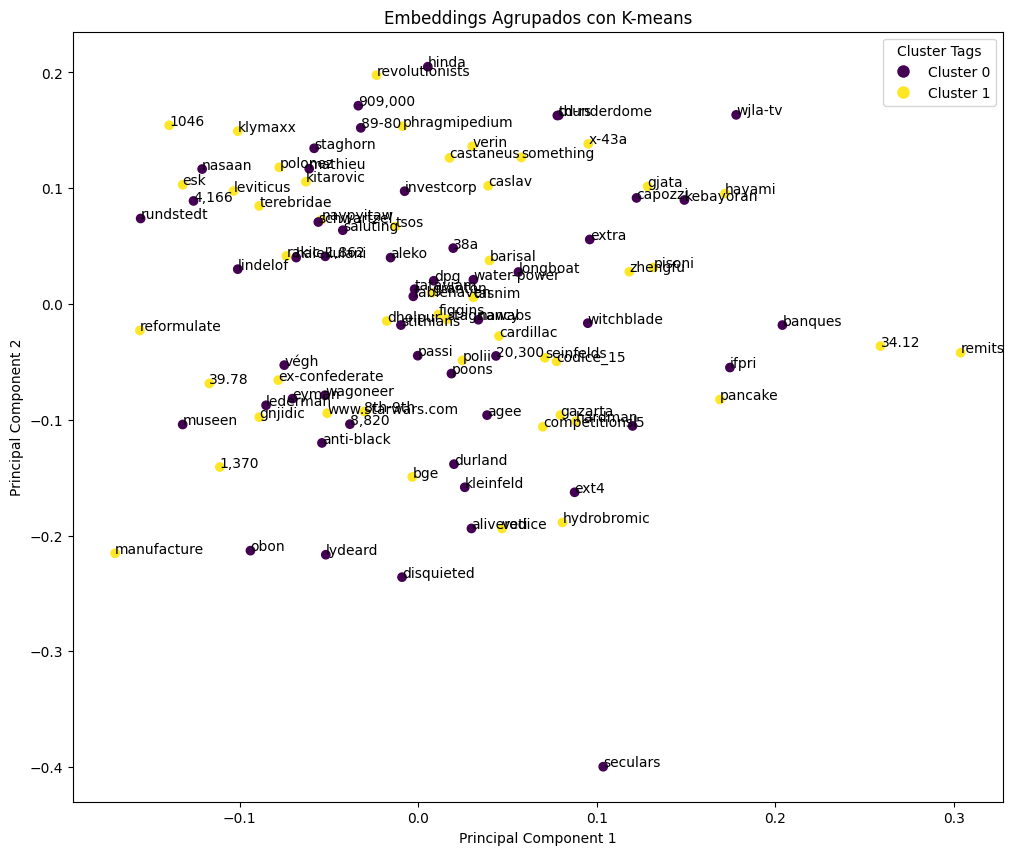

In [49]:
# Now call the modified function
pca2_with_clusters(embeddings, N, indices, idx_2_word, cluster_labels)

### Solo usé dos grupos porque más adelante ví que en esta selección aleatoria solo había dos categorías. Entonces para hacer más sencilla la visualización decidí tomar este número. En principio había escogido usar las 19 categorías pero eran muchos colores y muy confuso.

## **Paso 3:** Agrega al **plot** de los **embeddings** sus etiquetas **POS** correspondientes. Utiliza un marcador que las distinga claramente de las palabras.

<ipython-input-46-6744926e11a4>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(index_to_pos))


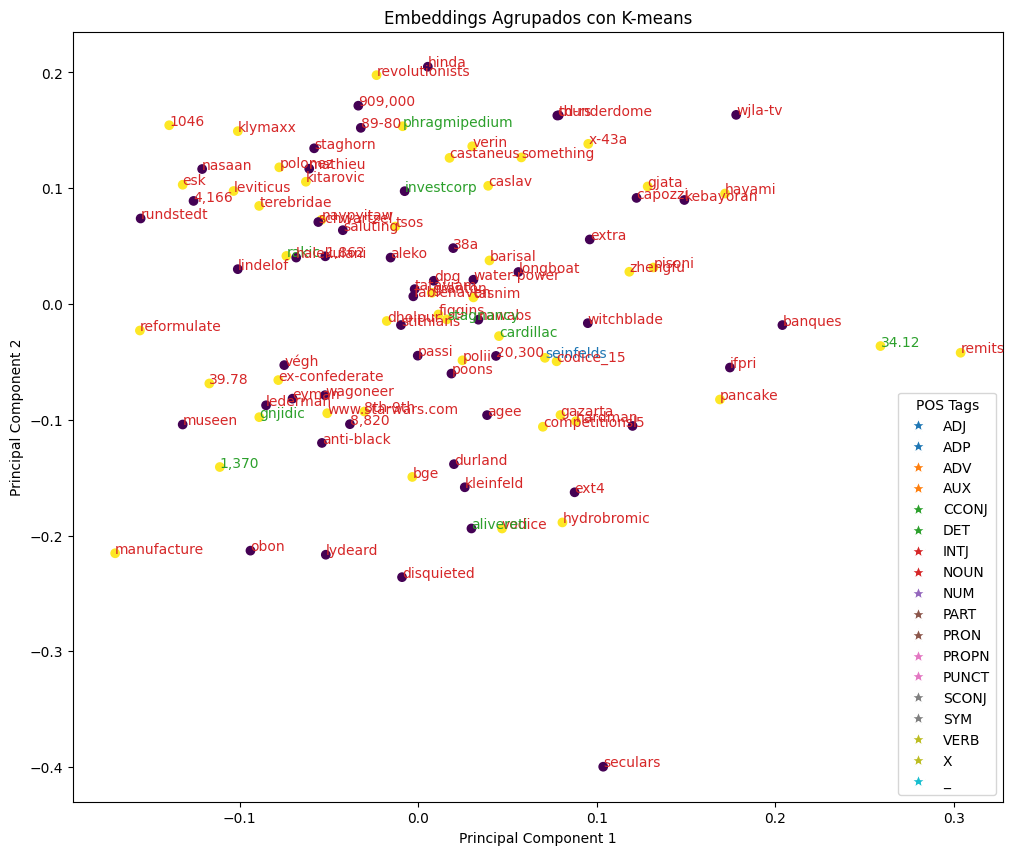

In [50]:
pca2_with_clusters(embeddings, N, indices, idx_2_word, cluster_labels,idx_2_pos)

### Las etiquetas POS están definidas por el color que toma el nombre de la palabra. Si nos damos cuenta parece que solo hay dos categorías en esta selección: Noun y Det.

### Los colores de los grupos anteriores siguen siendo los mismos.



## Realiza una **conclusión** sobre los **resultados observados**

- ### Al principio me pareció sencillo, pero cuando comencé a realizar la práctica si me resultó difícil. Un problema que tuve fue poder usar el model que estaba en el drive, y al no poderlo cargar volví a entrenarlo con el código de la práctica 5.

- ### Otra dificultad que tuve fue el la selección del método para graficar tanto las POS predichas como las etiquetas de agrupación.

- ### También me costó un poco de trabajo enteder la sintaxis de como funcionan los modelos RNN y como usarlos en general ya que tienen muchas opciones.


- ### Como se ve en la última gráfica las categorías de agrupamiento no coinciden con las etiquetas POS. Y creo que esto tiene sentido y creo que en parte a esto es que se debe que se hayan intentado generar métodos más precisos y exactos, como son las RNN's. Creo que si es un salto muy muy grande.




